In [ ]:
# Uninstall any existing versions of TensorFlow
!pip uninstall tensorflow -y
# Install TensorFlow version 2.16.1
!pip install tensorflow==2.16.1

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
df = pd.read_csv('//content/ec2_cpu_utilization_24ae8d.csv')
df = df[['timestamp', 'value']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['value'], name='cpu usage'))
fig.update_layout(showlegend=True, title='cpu usage')
fig.show()

In [ ]:
print("Start date is: ", df['timestamp'].min())
print("End date is: ", df['timestamp'].max())


Start date is:  2014-02-14 14:30:00
End date is:  2014-02-28 14:25:00


# **Data Preprocessing**

In [ ]:
train = df.loc[df['timestamp'] <= '2014-02-25 14:30:00']
test = df.loc[df['timestamp'] > '2014-02-25 14:30:00']
train.shape, test.shape

((3169, 2), (863, 2))

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.array(train['value']).reshape(-1,1))

train['value'] = scaler.transform(np.array(train['value']).reshape(-1,1))
test['value'] = scaler.transform(np.array(test['value']).reshape(-1,1))

<ipython-input-105-f4929c09a8c1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-105-f4929c09a8c1>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



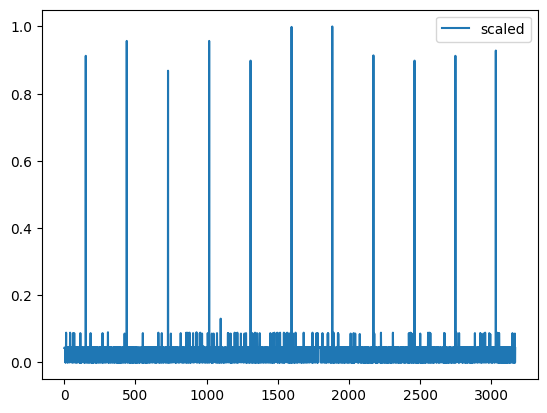

In [ ]:
plt.plot(train['value'], label = 'scaled')
plt.legend()
plt.show()

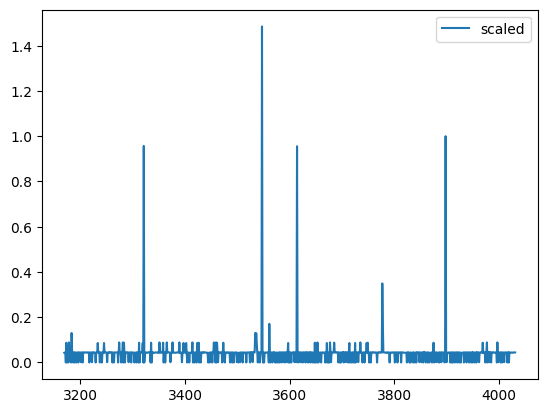

In [ ]:
plt.plot(test['value'], label = 'scaled')
plt.legend()
plt.show()

In [ ]:
TIME_STEPS=288

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (2881, 288, 1)
Testing input shape:  (575, 288, 1)


In [ ]:
#X_train[3158]

## **Build a model**

In [ ]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_5 (RepeatVec  (None, 288, 128)          0         
 tor)                                                            
                                                                 
 lstm_15 (LSTM)              (None, 288, 128)          131584    
                                                                 
 dropout_9 (Dropout)         (None, 288, 128)          0         
                                                                 
 time_distributed_5 (TimeDi  (None, 288, 1)            129       
 stributed)                                           

# **Train Model**

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
81/81 [==============================] - 70s 824ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 2/100
81/81 [==============================] - 66s 819ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 3/100
81/81 [==============================] - 64s 792ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 4/100
81/81 [==============================] - 62s 763ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/100
81/81 [==============================] - 63s 782ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/100
81/81 [==============================] - 62s 762ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/100
81/81 [==============================] - 64s 790ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8/100
81/81 [==============================] - 66s 813ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/100
81/81 [==============================] - 64s 786ms/step - loss: 0.0032 - val_loss: 0.0032


In [ ]:
from tensorflow.keras.models import save_model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



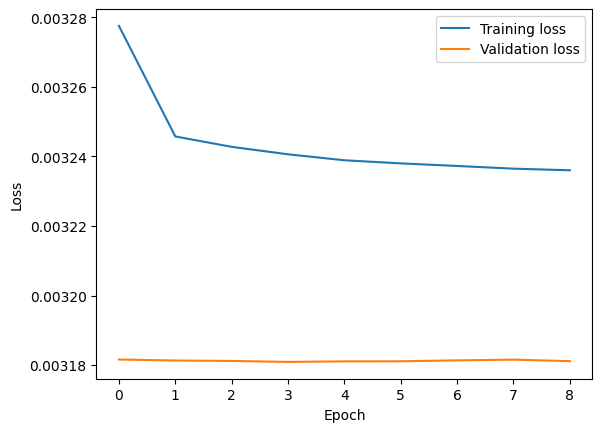

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

91/91 [==============================] - 27s 283ms/step
Reconstruction error threshold: 0.033913162151009826


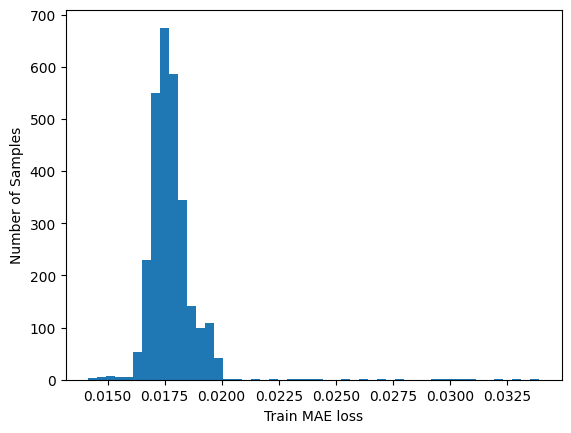

In [ ]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

# **Predict Anomalies on test data using threshold**

18/18 [==============================] - 6s 353ms/step


Text(0, 0.5, 'Number of samples')

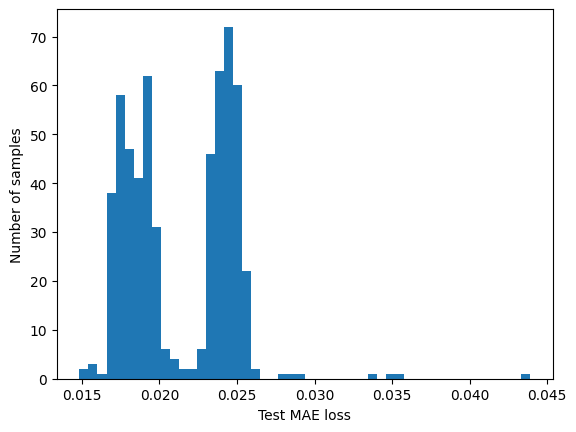

In [ ]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [ ]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [ ]:
anomaly_df.head()

,timestamp,value,loss,threshold,anomaly
3457,2014-02-26 14:35:00,0.043025,0.016770,0.033913,False
3458,2014-02-26 14:40:00,0.000000,0.016891,0.033913,False
3459,2014-02-26 14:45:00,0.088657,0.017807,0.033913,False
3460,2014-02-26 14:50:00,0.000000,0.017036,0.033913,False
3461,2014-02-26 14:55:00,0.087353,0.017902,0.033913,False


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,timestamp,value,loss,threshold,anomaly
3548,2014-02-26 22:10:00,0.044329,0.043908,0.033913,True
3549,2014-02-26 22:15:00,0.000000,0.035464,0.033913,True
3899,2014-02-28 03:25:00,0.043025,0.035034,0.033913,True


In [ ]:
anomalies.shape

(3, 5)

In [ ]:
anomaly_values = anomaly_df['value'].values.reshape(-1, 1)
anomaly_inverse_values = scaler.inverse_transform(anomaly_values)

anomalies_values = anomalies['value'].values.reshape(-1, 1)
anomalies_inverse_values = scaler.inverse_transform(anomalies_values)

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_inverse_values.flatten(), name='cpu usage'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=anomalies_inverse_values.flatten(), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()
